In [34]:
import numpy
import time
import gtsam
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

In [35]:
# helper functions

def plot_graph(graph, values, color="b", is3D=False, label=None):
    fig = plt.figure()
    # plot edges
    for i in range(graph.size()):
        factor = graph.at(i)
        if len(factor.keys()) == 1:
            # draw a prior as a circle
            key = factor.keys()[0]
            pose = values.atPose2(key) if not is3D else values.atPose3(key)
            plt.scatter(pose.x(), pose.y(), color='r', marker="o", s=100)
        else:
            key1 = factor.keys()[0]
            key2 = factor.keys()[1]
            pose1 = values.atPose2(key1) if not is3D else values.atPose3(key1)
            pose2 = values.atPose2(key2) if not is3D else values.atPose3(key2)
            plt.scatter(pose1.x(), pose1.y(), color=color, marker="o", s=1)
            plt.plot(
                [pose1.x(), pose2.x()],
                [pose1.y(), pose2.y()],
                color=color,
                label=label,
                linewidth=0.5,
                alpha=0.5,
            )
    plt.axis("equal")
    plt.show()

def covarianceToEllipse(covariance, nsig=1):
    """
    Convert a 2D covariance matrix to ellipse.
    """
    # Get the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = numpy.linalg.eig(covariance)
    # Get the largest eigenvalue and its eigenvector
    max_eigenvalue = numpy.max(eigenvalues)
    max_eigenvalue_index = numpy.argmax(eigenvalues)
    max_eigenvector = eigenvectors[:, max_eigenvalue_index]
    # Get the smallest eigenvalue and its eigenvector
    min_eigenvalue = numpy.min(eigenvalues)
    min_eigenvalue_index = numpy.argmin(eigenvalues)
    min_eigenvector = eigenvectors[:, min_eigenvalue_index]
    # Calculate the angle of the largest eigenvector
    angle = numpy.arctan2(max_eigenvector[1], max_eigenvector[0])
    # Return the ellipse parameters
    return (
        numpy.sqrt(max_eigenvalue) * nsig,
        numpy.sqrt(min_eigenvalue) * nsig,
        angle,
    )

def plot_ellipse(values, covs, nsig=1, color="b", label=None):
    # check covs' dimension
    is3D = False if covs[0].shape == (3, 3) else True
    fig = plt.figure()
    for key in values.keys():
        pose = values.atPose2(key) if not is3D else values.atPose3(key)
        cov = covs[key] if not is3D else covs[key][0:2, 0:2]
        a, b, angle = covarianceToEllipse(cov, nsig)
        plt.scatter(pose.x(), pose.y(), color=color, marker="o", s=1)
        ellipse = Ellipse(
            (pose.x(), pose.y()),
            2 * a,
            2 * b,
            angle=angle ,
            fill=True,
            color=color,
            label=label,
        )
        plt.gca().add_artist(ellipse)
    plt.axis("equal")
    plt.show()

Initial error: Optimization complete

final error = 20.206765126253824
1.10891e+06, values: 1045
iter      cost      cost_change    lambda  success iter_time
   0  2.263964e+04    1.09e+06    1.00e-05     1    0.00e+00
   1  2.099553e+01    2.26e+04    1.00e-06     1    0.00e+00
   2  2.020691e+01    7.89e-01    1.00e-07     1    1.00e-02
   3  2.020677e+01    1.45e-04    1.00e-08     1    1.00e-02


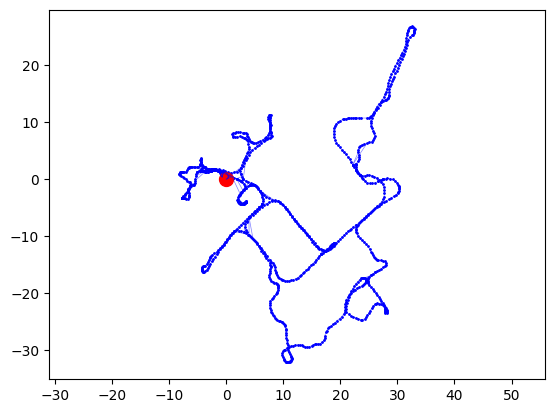

In [36]:
g2o_filename = "data/CSAIL.g2o"
is3D = False

# import the g2o file
graph, values = gtsam.readG2o(g2o_filename, is3D)
# add a prior on key 0
priorMean = gtsam.Pose2(0, 0, 0) if not is3D else gtsam.Pose3()
priorNoise = (
    gtsam.noiseModel.Diagonal.Sigmas(numpy.array([0.1, 0.1, 0.1]))
    if not is3D
    else gtsam.noiseModel.Diagonal.Sigmas(numpy.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1]))
)
graph.add(gtsam.PriorFactorPose2(0, priorMean, priorNoise))


# optimize with Levenberg-Marquardt optimization
params = gtsam.LevenbergMarquardtParams()
params.setVerbosityLM("SUMMARY")
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, values, params)
result = optimizer.optimize()

# print result
print("Optimization complete\n")
print("final error = {}".format(graph.error(result)))

# plot the graph
plot_graph(graph, result, color="b", is3D=is3D, label="before")

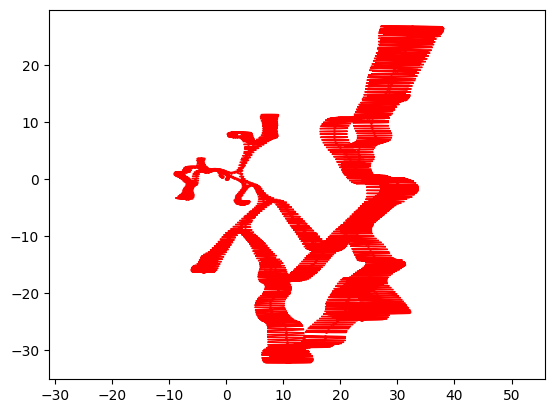

CPU times: user 3.7 s, sys: 225 ms, total: 3.92 s
Wall time: 3.76 s


In [39]:
%%time
# marginalize the graph
marginals= gtsam.Marginals(graph, result)
covariances = {}
for i in range(len(result.keys())):
    key = result.keys()[i]
    marginal = marginals.marginalCovariance(key)
    covariances[key] = marginal


In [ ]:

# plot the graph with covariances
plot_ellipse(result, covariances, nsig=1, color="r", label="after")

In [ ]:
%%time
def fast_marginalize(graph, values) -> {}:
  pass
fast_covariance= fast_marginalize(graph, result)

In [ ]:
# plot the graph with covariances
plot_ellipse(result, fast_covariance, nsig=1, color="r", label="after")